# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [140]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [141]:
data.shape

(13150, 10)

In [142]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [301]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [302]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

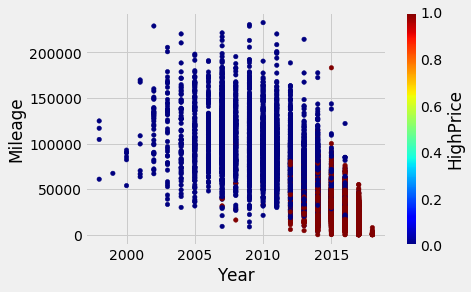

In [303]:
data.plot(kind='scatter', x='Year', y='Mileage', c='HighPrice', colormap='jet')

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [505]:
max_depth = None  #
num_pct = 10 #
max_features = None #
min_gain=0.001 #

In [506]:
j = 1
print(X.columns[j])

Mileage


In [507]:
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())

In [508]:
splits = np.unique(splits)

In [509]:
splits

array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [510]:
k = 3

In [511]:
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [512]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [513]:
gini_l = gini(y_l) #la ganancia de hacer una particion del lado izq
gini_l

0.10711336645671388

In [514]:
gini_r = gini(y_r)
gini_r

0.48835136419789327

In [515]:
def gini_impurity(X_col, y, split): #ojo con este 
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split #vector booleano
    y_l = y.loc[filter_l] #iquierdo 
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y) #gidi total
    gini_l = gini(y_l) #nodo iz
    gini_r = gini(y_r) #nodo der
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r) #cuantas de lado izq y lado der, se pondera podria mandar una sola observacion y un gini que llegue a infinito, lo mas visibles y separe la mayor cantidad de observaciones
    
    return gini_impurity_

In [516]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.11336562635752745

In [517]:
def best_split(X, y, num_pct=10): #de 10 en 10
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [518]:
j, split, gain = best_split(X, y, 5) #indice, particion y ganancia
j, split, gain

(0, 2014.0, 0.23223870086324505)

In [519]:
X.columns[0]

'Year'

In [520]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [521]:
y.shape[0], y_l.shape[0], y_r.shape[0]

(13150, 4169, 8981)

In [522]:
y.mean(), y_l.mean(), y_r.mean()

(0.5795437262357415, 0.07939553849844087, 0.8117136176372342)

In [523]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10): #
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain) #gain=-1
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    # tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [524]:
tree_grow(X, y, level=0, min_gain=0.001, max_depth=1, num_pct=10)

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': -1,
  'n_samples': 8368,
  'gain': 0.0359166442135464},
 'sr': {'y_pred': 0,
  'y_prob': 0.12771739130434784,
  'level': 1,
  'split': -1,
  'n_samples': 4782,
  'gain': 0.04846022210319853}}

In [525]:
tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [526]:
tree

{'y_pred': 1,
 'y_prob': 0.5795316301703163,
 'level': 0,
 'split': [1, 51704.54545454545],
 'n_samples': 13150,
 'gain': 0.23348567756020572,
 'sl': {'y_pred': 1,
  'y_prob': 0.8377538829151733,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 8368,
  'gain': 0.0359166442135464,
  'sl': {'y_pred': 0,
   'y_prob': 0.3403880070546737,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 565,
   'gain': 0.06001982703810749,
   'sl': {'y_pred': 0,
    'y_prob': 0.058823529411764705,
    'level': 3,
    'split': -1,
    'n_samples': 151,
    'gain': 0.005661757290357922},
   'sr': {'y_pred': 0,
    'y_prob': 0.44471153846153844,
    'level': 3,
    'split': -1,
    'n_samples': 414,
    'gain': 0.030742158715547196}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8737988468930173,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 7803,
   'gain': 0.015250286354762527,
   'sl': {'y_pred': 1,
    'y_prob': 0.731399157697707,
    'level': 3,
    'split': -1,
    'n_samples': 2135,
    'ga

In [527]:
def tree_predict(X, tree, proba=False): #X es X_test
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [528]:
metrics.accuracy_score(y_pred, y_test)

0.7397718631178707

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [482]:
X_train = data.iloc[:, 1:]
y_train = data.iloc[:, 0]
X_test = data.iloc[:, 1:]
y_test = data.iloc[:, 0]

In [483]:
np.random.seed(123)
nums = np.arange(1, 10)
print(nums)
print(np.random.choice(a=nums, size=10, replace=True))

[1 2 3 4 5 6 7 8 9]
[3 3 7 2 4 7 2 1 2 1]


In [484]:
np.random.seed(123)

n_samples = data.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
samples

[array([ 3582, 11646,  1346, ...,  7609,   826, 12472]),
 array([10086, 12583,  8676, ...,  6654, 12680,  6930]),
 array([ 3187,  9506, 13104, ...,   514, 11198, 12789]),
 array([ 7975,  7978, 10938, ...,  9423,  6330,   143]),
 array([10073, 10404,  3054, ...,  8839,  2273, 11157]),
 array([ 5772,  6551,  9436, ..., 11150, 11918,  6274]),
 array([1233, 2545, 3665, ..., 1811, 7815, 6039]),
 array([10496,  4279,  5665, ...,  2733,  1011,   606]),
 array([ 2134,  6321,  9507, ...,  6330, 12601,  5561]),
 array([12956,  4255,  7224, ...,  9162,  3592, 10236])]

In [485]:
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

y_pred_1 = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

for j, sample in enumerate(samples):
    X_train = data.iloc[sample, 1:]
    y_train = data.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred_1[j] = treereg.predict(X_test)

In [486]:
dtc = DecisionTreeClassifier(max_depth=None, random_state=123)
dtc.fit(X_train, y_train)
y_pred_1 = dtc.predict(X_test)
metrics.accuracy_score(y_pred_1, y_test)

0.7404562737642586

# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [487]:
X.columns

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [488]:
dtc1 = DecisionTreeClassifier(max_features=1, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.7403802281368821

In [489]:
dtc1 = DecisionTreeClassifier(max_features=2, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.7406083650190114

In [490]:
dtc1 = DecisionTreeClassifier(max_features=3, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.7403802281368821

In [491]:
dtc1 = DecisionTreeClassifier(max_features=4, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.7404562737642586

In [492]:
dtc1 = DecisionTreeClassifier(max_features=5, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.7403802281368821

In [493]:
dtc1 = DecisionTreeClassifier(max_features=6, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.7406844106463878

In [494]:
dtc1 = DecisionTreeClassifier(max_features=7, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.74

In [495]:
dtc1 = DecisionTreeClassifier(max_features=8, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.740532319391635

In [496]:
dtc1 = DecisionTreeClassifier(max_features=9, random_state=123)
dtc1.fit(X_train, y_train)
y_pred_2 = dtc1.predict(X_test)
metrics.accuracy_score(y_pred_2, y_test)

0.7404562737642586

### Las variaciones son mínimas, el min accuracy es de 0.74 con max_features=7 y el max accuracy es de 0.74068 con max_features=6

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [497]:
clf_log = BaggingClassifier(DecisionTreeClassifier(max_features="log2"), n_estimators=10, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf_log.fit(X_train, y_train)
y_pred_3 = clf_log.predict(X_test)
metrics.accuracy_score(y_pred_3, y_test)

C:\Users\rangarita\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:605: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\rangarita\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:610: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


0.712319391634981

# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [498]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [499]:
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
metrics.accuracy_score(y_pred_rf, y_test)

0.7108745247148289

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [500]:
estimator_range = range(10, 310, 10)

accuracy_scores = []

for estimator in estimator_range:
    clf_e = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf_e, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

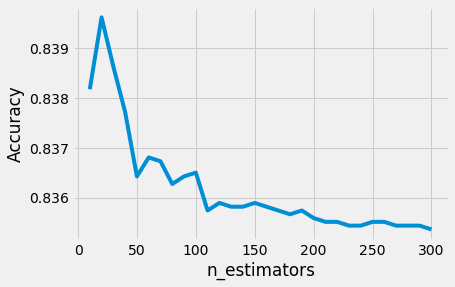

In [501]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [256]:
feature_range = range(1, len("highPrice")+1)

accuracy_scores = []

for feature in feature_range:
    clf_mf = RandomForestClassifier(n_estimators=20, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf_mf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

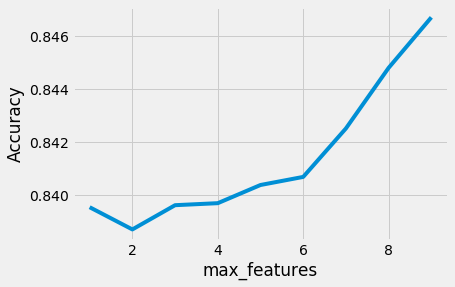

In [257]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [275]:
max_depth_range = range(1, 21)

accuracy_scores = []

for depth in max_depth_range:
    clf_md = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf_md, X, y, cv=10, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

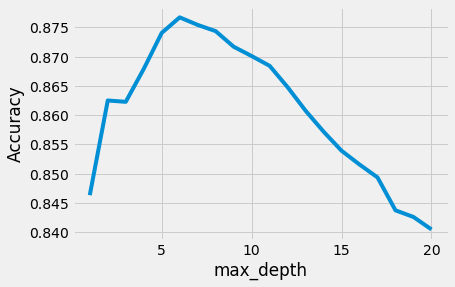

In [276]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [277]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.8767310653193674, 6)